In [1]:
#imports
import numpy as np
import pandas as pd
import random
import string

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import csv
import datetime
from datetime import timedelta,datetime, date

from scipy import stats

In [2]:
cl = pd.read_parquet("customers.parquet")
tr = pd.read_parquet("transactions.parquet")

In [3]:
print(cl.shape)
print(tr.shape)

(13329, 2)
(29002993, 9)


In [4]:
len(cl.CUST_ID.unique())

9835

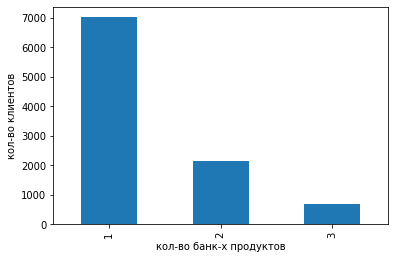

In [5]:
grp = cl.groupby("CUST_ID",as_index= False).count().groupby("PROD_TYPE").count()
p = grp.plot(kind= "bar", xlabel= "кол-во банк-х продуктов", 
         ylabel= "кол-во клиентов", legend= False)
p.figure.savefig("outputs/1_prod_num_distrib.png", dpi= 600, transparent= False, 
  facecolor= "white", bbox_inches= "tight")

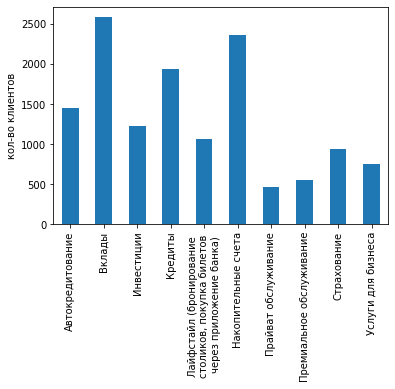

In [6]:
grp = cl.groupby("PROD_TYPE").count()
xticks = grp.index.values.to_list()
xticks[4] = "Лайфстайл (бронирование \nстоликов, покупка билетов \nчерез приложение банка)"
ax = grp.plot(kind= "bar", legend= False, xlabel= "", ylabel= "кол-во клиентов")
ax.set_xticklabels(xticks)
ax.figure.savefig("outputs/2_prod_distrib.png", dpi= 600, transparent= False, 
  facecolor= "white", backend= "cairo", bbox_inches= "tight")
None

### поиск ошибок и аутлайеров

In [7]:
origrownum = tr.shape[0]

In [8]:
print("START_DATE: {} -- {}".format(tr.START_DATE.min(), tr.START_DATE.max()))
print("END_DATE: {} -- {}".format(tr.START_DATE.min(), tr.END_DATE.max()))
print("DATE: {} -- {}".format(tr.DATE.min(), tr.DATE.max()))
print("YEAR: {} -- {}".format(tr.YEAR.min(), tr.YEAR.max()))
print("MONTH: {} -- {}".format(tr.MONTH.min(), tr.MONTH.max()))
print("DAY: {} -- {}".format(tr.DAY.min(), tr.DAY.max()))

START_DATE: 2014-05-27 00:00:00 -- 2019-11-30 00:00:00
END_DATE: 2014-05-27 00:00:00 -- 2020-11-27 00:00:00
DATE: 1921-01-13 00:00:00 -- 2112-06-26 00:00:00
YEAR: -1 -- 2112
MONTH: -1 -- 12
DAY: -1 -- 27


In [9]:
((tr.END_DATE.isna() & (tr.YEAR > 2020)) | 
 (tr.END_DATE.notna() & (tr.DATE > tr.END_DATE))).sum(), \
 ((tr.DATE < tr.START_DATE) | (tr.YEAR < 0) | (tr.MONTH < 0) | \
  (tr.DAY < 0)).sum()

(10, 59)

In [10]:
tr = tr.loc[ 
    np.logical_not(
      (tr.END_DATE.isna() & (tr.YEAR > 2020)) | 
      (tr.END_DATE.notna() & (tr.DATE > tr.END_DATE)) |
      (tr.DATE < tr.START_DATE)  | (tr.YEAR < 0) | (tr.MONTH < 0) | \
      (tr.DAY < 0)
    ), :
  ];

In [11]:
((tr.END_DATE.isna() & (tr.YEAR > 2020)) | 
 (tr.END_DATE.notna() & (tr.DATE > tr.END_DATE))).sum(), \
 ((tr.DATE < tr.START_DATE) | (tr.YEAR < 0) | (tr.MONTH < 0) | \
  (tr.DAY < 0)).sum()

(0, 0)

### поиск аутлайеров в AMOUNT

In [12]:
tr.AMOUNT.isna().sum()

21

In [13]:
tr.loc[tr.AMOUNT.isna(), "AMOUNT"] = tr.AMOUNT.mean()

In [14]:
tr.AMOUNT.quantile(np.linspace(0, 1, 10))

0.000000          -1.00
0.111111          98.59
0.222222         125.67
0.333333         185.13
0.444444         274.64
0.555556         439.38
0.666667         713.15
0.777778        1152.40
0.888889        2429.93
1.000000    99058810.00
Name: AMOUNT, dtype: float64

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

### поиск аутлайеров измерением zscore

In [15]:
x = np.abs(stats.zscore(tr.AMOUNT))
ol1 = x > 3
print(np.where(ol1))
print(ol1.sum())
print(tr.loc[ol1, 'AMOUNT'])

(array([   23191,   233154,   504135,   820353,  1342033,  2119003,
        3034652,  3285077,  3315908,  3669823,  3801981,  3828006,
        4111414,  4619472,  4720902,  5776979,  5962900,  6475624,
        6811188,  7104614,  7533245,  7699453,  8246143,  9998436,
       10224156, 11080001, 11411711, 11540664, 11802398, 11901299,
       11984650, 12187113, 13397664, 13685716, 13934347, 14045514,
       15127911, 15523571, 15668470, 15888360, 16212603, 16428418,
       16732663, 17113215, 17280707, 17508683, 18040042, 18548192,
       18812316, 19047679, 19135449, 19567083, 19795088, 20514799,
       20616285, 20616637, 20685476, 20690090, 20855543, 21183776,
       21466256, 21572702, 21679710, 21788058, 22665535, 22937619,
       23000149, 23277650, 23407748, 23462928, 23782239, 23856807,
       24243592, 24793039, 26308968, 26402289, 26513412, 26743768,
       26894039, 26970697, 27250936, 27440450, 27633582, 27801410,
       27987589, 28677877, 28692703, 28699180, 28917837]),)
8

### поиск аутлайеров измерением относительно IRQ

In [16]:
Q1 = tr.AMOUNT.quantile(0.25)
Q3 = tr.AMOUNT.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
ol2 = (tr.AMOUNT < (Q1 - 1.5 * IQR)) | (tr.AMOUNT > (Q3 + 1.5 * IQR))
print(np.where(ol2))
print(ol2.sum())
print(tr.AMOUNT[ol2])

874.9100000000001
(array([       1,       63,       70, ..., 28692703, 28699180, 28917837]),)
3355221
1               6017.57
63              7049.08
70              2621.42
78              6907.23
83              6254.22
               ...     
28391110        2503.76
28677945    48390641.00
28692771    37081062.00
28699248    39414680.00
28917905    13034049.00
Name: AMOUNT, Length: 3355221, dtype: float64


### результаты фильтрации на основании zscore выглядят правдоподобнее

In [17]:
tr = tr.loc[np.logical_not(ol1), :]
tr.shape[0]

29002835

### удаляём с отриц. значением amount

In [18]:
tr = tr.loc[tr.AMOUNT >= 0, :]
tr.shape[0]

29002793

In [19]:
print("Было удалено {} потенциальных аутлайеров".format(origrownum- tr.shape[0]))

Было удалено 200 потенциальных аутлайеров


In [20]:
tr.to_parquet("transactions_2_cleaned.parquet")

### первичный стат. анализ

In [21]:
uniqexptypes = tr.EXP_TYPE.value_counts()
uniqexptypes = uniqexptypes.sort_index()
uniqexptypes

Авиалинии, авиакомпании                642234
Автомобильные сервисы                  590330
Аптеки                                 212916
Аренда авто                            807098
Аренда жилья                            70324
Бакалейные магазины, супермаркеты     1000444
Билеты кино, музеи, театры, шоу       2399881
Визовые центры                           1468
Книжные магазины                      2953732
Коммунальные услуги                     72468
Мебельные магазины                      71945
Медицинские учреждения                 213423
Музыкальные инструменты               2958718
Налоговые платежи                      144493
Образовательные услуги                 146297
Одежда и обувь                         181693
Операторы связи                         71259
Отели, мотели, курорты                 595663
Пригородное сообщение                  713962
Продажа авто                           761709
Путешествия                            634604
Развлечения                       

In [22]:
grp = cl.groupby("CUST_ID").\
  aggregate(lambda x: x.to_list())
cltoprod = {x:y  for (x,y) in zip(grp.index, grp.PROD_TYPE)}
cltoprod

{0: ['Накопительные счета', 'Вклады'],
 1: ['Накопительные счета'],
 2: ['Накопительные счета'],
 3: ['Кредиты'],
 4: ['Автокредитование'],
 5: ['Кредиты'],
 6: ['Услуги для бизнеса', 'Прайват обслуживание', 'Автокредитование'],
 7: ['Накопительные счета', 'Кредиты'],
 8: ['Прайват обслуживание'],
 9: ['Вклады'],
 10: ['Автокредитование', 'Страхование'],
 11: ['Вклады'],
 12: ['Страхование'],
 13: ['Вклады'],
 14: ['Накопительные счета'],
 15: ['Вклады'],
 16: ['Лайфстайл (бронирование столиков, покупка билетов через приложение банка)'],
 17: ['Премиальное обслуживание'],
 18: ['Автокредитование', 'Вклады'],
 19: ['Кредиты', 'Автокредитование'],
 20: ['Страхование'],
 21: ['Автокредитование'],
 22: ['Премиальное обслуживание', 'Накопительные счета'],
 23: ['Страхование', 'Инвестиции'],
 24: ['Накопительные счета'],
 25: ['Премиальное обслуживание'],
 26: ['Лайфстайл (бронирование столиков, покупка билетов через приложение банка)',
  'Вклады'],
 27: ['Инвестиции'],
 28: ['Накопительные 

In [23]:
d = []
prodtypes_counter = {k:0.0  for k in cl.PROD_TYPE.cat.categories}
trsum = tr.AMOUNT.sum()
for (key, val) in uniqexptypes.iteritems():
  ptc = prodtypes_counter.copy()
  grp = tr.loc[tr.EXP_TYPE == key, ["CUST_ID", "AMOUNT"]]
  sumgrp = grp.AMOUNT.sum()
  for (c, a) in zip(grp.CUST_ID, grp.AMOUNT):
    for pt in cltoprod[c]:
      ptc[pt] += a / sumgrp
  d.append({
      "exp_type": key,   "prop": val / tr.shape[0],   
      "prop_amount": grp.AMOUNT.sum() / trsum
    } | ptc)
dfstats1 = pd.DataFrame(d)
dfstats1

,exp_type,prop,prop_amount,Автокредитование,Вклады,Инвестиции,Кредиты,"Лайфстайл (бронирование столиков, покупка билетов через приложение банка)",Накопительные счета,Прайват обслуживание,Премиальное обслуживание,Страхование,Услуги для бизнеса
0,"Авиалинии, авиакомпании",0.022144,0.034541,0.140228,0.284476,0.111627,0.197613,0.112525,0.229510,0.053176,0.062255,0.097569,0.072802
1,Автомобильные сервисы,0.020354,0.032975,0.166737,0.264106,0.118761,0.197992,0.105045,0.241872,0.043356,0.058035,0.100092,0.078931
2,Аптеки,0.007341,0.019036,0.143787,0.271338,0.113312,0.196356,0.113251,0.243389,0.040838,0.055797,0.121380,0.069997
3,Аренда авто,0.027828,0.034687,0.173869,0.253202,0.122855,0.184112,0.108616,0.252256,0.047350,0.054146,0.099095,0.070278
4,Аренда жилья,0.002425,0.018564,0.142490,0.243165,0.110109,0.190975,0.098781,0.283240,0.042342,0.059350,0.105896,0.086040
5,"Бакалейные магазины, супермаркеты",0.034495,0.042720,0.155237,0.264475,0.112123,0.210992,0.102892,0.231611,0.042158,0.052842,0.120103,0.075064
6,"Билеты кино, музеи, театры, шоу",0.082747,0.038009,0.139351,0.260831,0.120605,0.215223,0.129388,0.227545,0.044807,0.056907,0.097510,0.076282
7,Визовые центры,0.000051,0.000373,0.145231,0.254161,0.082946,0.165671,0.119495,0.274972,0.060798,0.040904,0.092546,0.071205
8,Книжные магазины,0.101843,0.038987,0.143047,0.296732,0.138319,0.191462,0.098809,0.225439,0.043380,0.059209,0.095641,0.077070
9,Коммунальные услуги,0.002499,0.019950,0.139073,0.293655,0.127049,0.179476,0.095940,0.258325,0.040261,0.056832,0.084950,0.075265


In [24]:
d = {x:{"exp_type": x, **prodtypes_counter} for x in tr.EXP_TYPE.cat.categories}
for pt in cl.PROD_TYPE.unique():
  custs = cl.loc[cl.PROD_TYPE == pt, "CUST_ID"]
  grp = tr.loc[tr.CUST_ID.isin(custs), ["EXP_TYPE", "AMOUNT"]]
  grpsum = grp.AMOUNT.sum()
  for (et, am) in zip(grp.EXP_TYPE, grp.AMOUNT):
    d[et][pt] += am / grpsum
    

In [25]:
dfstats2 = pd.DataFrame(d.values())
dfstats2

,exp_type,Автокредитование,Вклады,Инвестиции,Кредиты,"Лайфстайл (бронирование столиков, покупка билетов через приложение банка)",Накопительные счета,Прайват обслуживание,Премиальное обслуживание,Страхование,Услуги для бизнеса
0,"Авиалинии, авиакомпании",0.032442,0.036753,0.031881,0.034329,0.035396,0.033175,0.040535,0.038130,0.032932,0.032749
1,Автомобильные сервисы,0.036825,0.032574,0.032379,0.032834,0.031544,0.033376,0.031551,0.033933,0.032251,0.033896
2,Аптеки,0.018332,0.019319,0.017834,0.018798,0.019632,0.019388,0.017156,0.018833,0.022578,0.017353
3,Аренда авто,0.040394,0.032851,0.035235,0.032118,0.034311,0.036617,0.036247,0.033303,0.033588,0.031747
4,Аренда жилья,0.017717,0.016885,0.016901,0.017830,0.016700,0.022004,0.017347,0.019536,0.019210,0.020802
5,"Бакалейные магазины, супермаркеты",0.044418,0.042260,0.039604,0.045332,0.040029,0.041406,0.039746,0.040028,0.050137,0.041763
6,"Билеты кино, музеи, театры, шоу",0.035475,0.037081,0.037902,0.041141,0.044786,0.036193,0.037585,0.038353,0.036216,0.037759
7,Визовые центры,0.000362,0.000354,0.000256,0.000310,0.000405,0.000429,0.000500,0.000270,0.000337,0.000346
8,Книжные магазины,0.037354,0.043271,0.044588,0.037541,0.035082,0.036781,0.037325,0.040932,0.036436,0.039132
9,Коммунальные услуги,0.018583,0.021913,0.020957,0.018007,0.017430,0.021567,0.017726,0.020104,0.016561,0.019555


In [26]:
dfstats1.to_excel("outputs/3_dfstats_exp_to_prod_props.xlsx")
dfstats2.to_excel("outputs/4_dfstats_prod_to_exp_props.xlsx")